# Mice Protein Expression

## Overview
The data set consists of the expression levels of 77 proteins/protein modifications that produced detectable signals in the nuclear fraction of cortex. There are 38 control mice and 34 trisomic mice (Down syndrome), for a total of 72 mice. In the experiments, 15 measurements were registered of each protein per sample/mouse. Therefore, for control mice, there are 38x15, or 570 measurements, and for trisomic mice, there are 34x15, or 510 measurements. The dataset contains a total of 1080 measurements per protein. Each measurement can be considered as an independent sample/mouse.

The eight classes of mice are described based on features such as genotype, behavior and treatment. According to genotype, mice can be control or trisomic. According to behavior, some mice have been stimulated to learn (context-shock) and others have not (shock-context) and in order to assess the effect of the drug memantine in recovering the ability to learn in trisomic mice, some mice have been injected with the drug and others have not.

You can find the raw data and more detailed description of the data here (https://archive-beta.ics.uci.edu/dataset/342/mice+protein+expression).

The objective is to build a classification model predicting the class label from the attributes. 

The training dataset contains 552 valid records with good qualities, the validation dataset contains 150 records with 17 columns as well as the class labels, and the testing dataset contains 150 columns but no class labels. Along with that, all data are consistent with non-negative numeric values. However, feature columns have missing values for all three datasets. In specific, columns "a10", "a11", "a13", "a15", "a16", and "a17" contains missing values.

## 1. Data Integration
In this part, all three datasets were concatenated together into a pandas DataFrame. In this part, all three datasets were concatenated together into a pandas DataFrame. The reason for concatenation is that we should keep the data consistent when we put the data into the machine learning models for training and prediction.


In [2]:
%matplotlib inline

# for file management
import os

# loading data and manipulating 
import pandas as pd
import numpy as np

#import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#get a helper function for splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split

#get a function to review the summary or profile of the data
from pandas_profiling import ProfileReport

# get a function for measuring test error
from sklearn.metrics import mean_absolute_error

#for visualising data
import matplotlib.pyplot as plt

#get the normalized data from skewness distribution
from scipy.stats import skew

#function for evaluating the accuracy of the models
from sklearn.metrics import accuracy_score

#apply k-fold to the dataset for training and validation
from sklearn.model_selection import KFold, StratifiedShuffleSplit

#get a helper function to culculate statistics of an array
from scipy import stats as st

#show f1 score and confusion matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
"""
Import the data from the database
combine test and validation to generate a larger data set
Describe of the "train" and "validation" data
"""
train = pd.read_csv("../input/data-1/training.csv")
valid = pd.read_csv("../input/data-1/validation.csv")
test = pd.read_csv("../input/data-1/test.csv")
all_data = pd.concat([train, valid, test], ignore_index=True) #concatenate train, test and vaidation

#keep testing set index
test_len, _ = test.shape
test_index = len(all_data) - test_len

valid_len, _ = valid.shape
valid_index = len(all_data) - test_len - valid_len

#show all_data
print(all_data.info())
print(all_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a1           852 non-null    float64
 1   a2           852 non-null    float64
 2   a3           852 non-null    float64
 3   a4           852 non-null    float64
 4   a5           852 non-null    float64
 5   a6           852 non-null    float64
 6   a7           852 non-null    float64
 7   a8           852 non-null    float64
 8   a9           852 non-null    float64
 9   a10          682 non-null    float64
 10  a11          621 non-null    float64
 11  a12          852 non-null    float64
 12  a13          793 non-null    float64
 13  a14          852 non-null    float64
 14  a15          700 non-null    float64
 15  a16          681 non-null    float64
 16  a17          633 non-null    float64
 17  class label  702 non-null    float64
dtypes: float64(18)
memory usage: 119.9 KB
None
       

<h1>Get the Profile of the data</h1>

In [4]:
# generate a profile regarding the data 1
profile = ProfileReport(all_data, title='Data1 Profile Report', explorative=True)
profile.to_file('ProfileReport.html')


# 2. Data Cleaning
After completing data integration, we should clean the data in the dataframe. Considering datasets in Data, we only need to handle missing data in all columns except “class label”.

As far as missing data is concerned, mean values would be filled in instead of dropping them. This is because we want to keep records as much as possible in the dataframe to increase the sample size in the training and validation process.

In [5]:
#set y as the label for training, validation
y = all_data['class label']
all_data = all_data.drop(["class label"], axis = 1)

#Drop out the record containing nan data
#all_data = all_data.drop(["class label"], axis = 1).dropna()


In [6]:
#standardization and dropping out outliers 
#drop records with data more than or less than n std

#Function of removing outliers
def remove_outliers(df,columns,n_std):
    for col in columns:
        #get the mean and the standard deviation of particular columns
        mean = df[col].mean()
        sd = df[col].std()
        
        #process missing nan data, choose the mean of that corresponding columns to fillin
        #assume outliers does not affect the result of the mean
        df[col] = df[col].fillna(df[col].mean())
        
        #filtering out outliers with values larger or smaller than n sd
        df = df[(df[col] <= mean+(n_std*sd))]
        df = df[(df[col] >= mean-(n_std*sd))]
        
    return df

#remove outliers on train and validation data
df = remove_outliers(all_data[all_data.index<valid_index], columns = all_data.columns[[*range(0,len(all_data.columns),1)]],n_std = 3)
df.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,0.125873,0.517375,0.287419,1.535918,2.239056,0.156069,1.230757,0.842053,0.222299,0.156344,0.134998,0.120776,0.127617,0.444061,0.163474,0.179292,0.197550
std,0.021164,0.077510,0.029516,0.236438,0.245300,0.022634,0.171610,0.090582,0.024114,0.024299,0.020938,0.014021,0.019568,0.063506,0.042404,0.032399,0.037178
min,0.073360,0.284000,0.215530,0.915740,1.511780,0.101230,0.830810,0.581930,0.155870,0.088300,0.092130,0.083800,0.090680,0.258630,0.082360,0.105540,0.104930
25%,0.109900,0.468040,0.266650,1.368190,2.081280,0.139430,1.107010,0.791330,0.203690,0.141600,0.123780,0.109840,0.113140,0.397660,0.131540,0.158100,0.173110
50%,0.123520,0.516030,0.285430,1.518130,2.237310,0.155410,1.220960,0.844940,0.222390,0.157713,0.135617,0.120650,0.127000,0.445270,0.166115,0.181880,0.200361
75%,0.142090,0.571440,0.308320,1.707300,2.419070,0.168750,1.351540,0.904420,0.237190,0.165740,0.137280,0.129910,0.136930,0.490050,0.178740,0.190930,0.209080
max,0.188310,0.731100,0.366770,2.193300,2.851440,0.222600,1.658790,1.119900,0.296840,0.246940,0.214600,0.158750,0.194510,0.605390,0.318040,0.289800,0.346060


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 551
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1      501 non-null    float64
 1   a2      501 non-null    float64
 2   a3      501 non-null    float64
 3   a4      501 non-null    float64
 4   a5      501 non-null    float64
 5   a6      501 non-null    float64
 6   a7      501 non-null    float64
 7   a8      501 non-null    float64
 8   a9      501 non-null    float64
 9   a10     501 non-null    float64
 10  a11     501 non-null    float64
 11  a12     501 non-null    float64
 12  a13     501 non-null    float64
 13  a14     501 non-null    float64
 14  a15     501 non-null    float64
 15  a16     501 non-null    float64
 16  a17     501 non-null    float64
dtypes: float64(17)
memory usage: 70.5 KB


# 3. Normalization

Besides, before model training, normalization had been applied to the dataframe. Likewise, the “class label” had been separated before normalization.

First of all, outliers with standard deviations (S.D.) greater than a threshold would be removed in the training parts since we want the model to be more general in predicting the class labels to prevent overfitting. In this case, we are concerned about outliers with S.D. larger than 3 in any columns in the training set. After removing, 51 records with outliers distributed across the columns have been removed.

Then, we scale the columns which have a skewness higher than a threshold with log transformation. After testing, the threshold is set to 0.7 and columns with skewness higher than that are transformed. 

At last, we rescale the dataframe which will clip the range of the data in dataframe between 0 and 1 using absolute maximum scaling. 


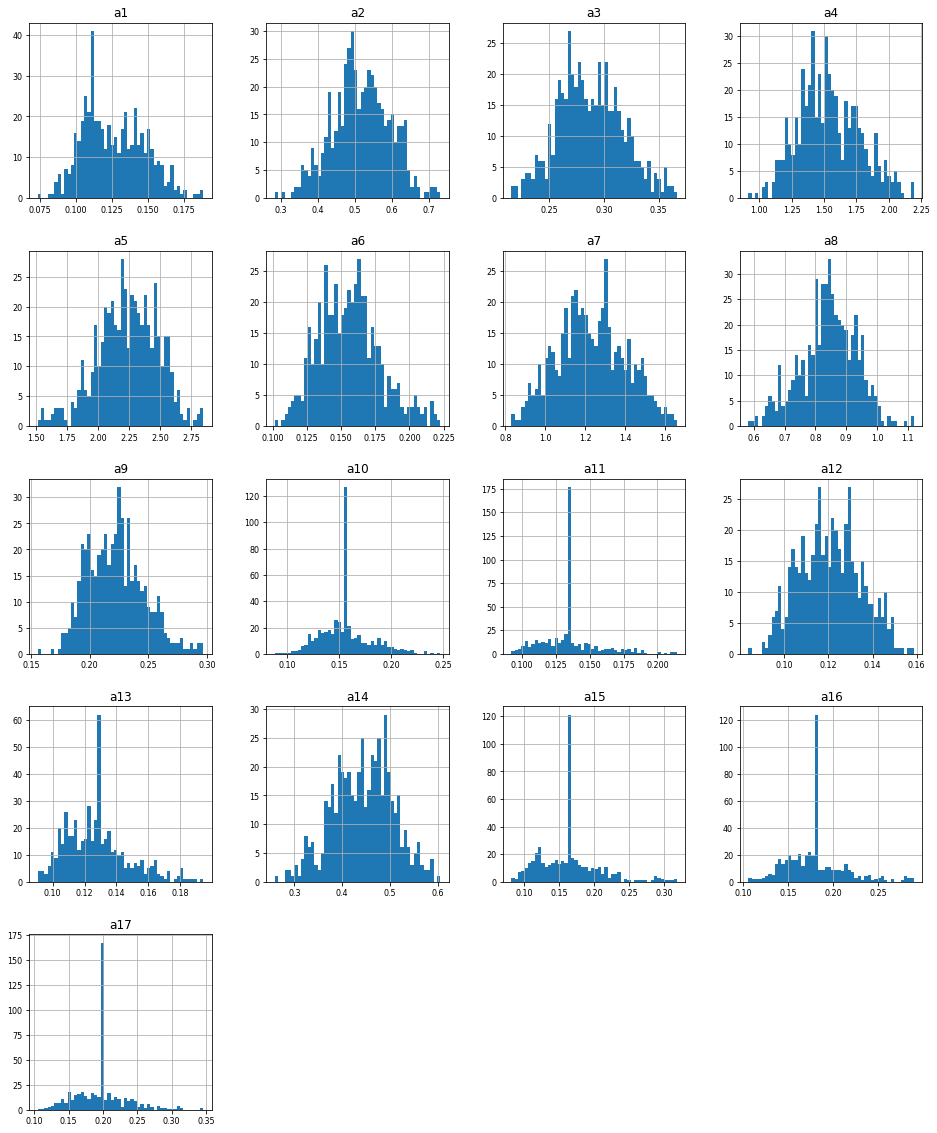

In [8]:
# view normalized training dataset

%matplotlib inline
df.iloc[:, :].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 
df_copy = df.copy()

In [9]:
#concatenate all datasets for further prepocessing
df = pd.concat((df, all_data[all_data.index>=valid_index].fillna(all_data.mean())), ignore_index=False)
df.describe()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17
count,801.000000,801.000000,801.000000,801.00000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.126048,0.521238,0.289469,1.54431,2.234036,0.157481,1.235095,0.847624,0.224591,0.156964,0.133963,0.121038,0.129007,0.444571,0.166666,0.180289,0.200275
std,0.021256,0.077158,0.029686,0.23897,0.243869,0.022694,0.167160,0.090419,0.026244,0.025265,0.021881,0.013982,0.020168,0.065164,0.050582,0.033069,0.041797
min,0.073360,0.284000,0.215530,0.91574,1.206100,0.101230,0.830810,0.581930,0.155870,0.088300,0.089510,0.083800,0.085420,0.258630,0.082360,0.105540,0.104930
25%,0.109330,0.474270,0.267870,1.37348,2.077180,0.141450,1.115190,0.796880,0.205740,0.140760,0.119530,0.110190,0.114240,0.397290,0.130050,0.158490,0.172750
50%,0.123880,0.522340,0.289370,1.52284,2.236930,0.156340,1.229310,0.847780,0.223160,0.157713,0.134365,0.120850,0.127730,0.446270,0.166115,0.181880,0.200361
75%,0.141940,0.571660,0.310300,1.71171,2.407930,0.170800,1.358210,0.914920,0.239960,0.167020,0.137810,0.130490,0.139960,0.490260,0.183810,0.192380,0.214450
max,0.188910,0.783110,0.443740,2.58622,2.851440,0.242970,1.897200,1.119900,0.344310,0.266190,0.261510,0.158750,0.205880,0.636280,0.479760,0.360690,0.376430


In [10]:
#standardize the data by normalizing the skewness

#calculate skewness
col_skew  = df.apply(lambda x: skew(x))

#find columns with skewness > threshold
threshold = 0.7
cols = col_skew[(col_skew)>threshold]
print(f"Columns with skewness > {threshold}")
print(cols, '\n')
skewed = cols.index
                                            
#apply log transform
df[skewed] = np.log1p(df[skewed])

#show skewness again
col_skew  = df.apply(lambda x: skew(x))
print(f"Columns after log transform:")
print(col_skew[cols.index])

Columns with skewness > 0.7
a10    0.757078
a11    1.187546
a13    0.730930
a15    1.852851
a16    1.023571
a17    0.882448
dtype: float64 

Columns after log transform:
a10    0.675699
a11    1.086455
a13    0.681097
a15    1.541802
a16    0.890906
a17    0.745640
dtype: float64


In [11]:
#Aplly normalization with max value of the columns
  
# apply normalization techniques
for col in df.columns:
    df[col] = df[col] / df[col].abs().max()

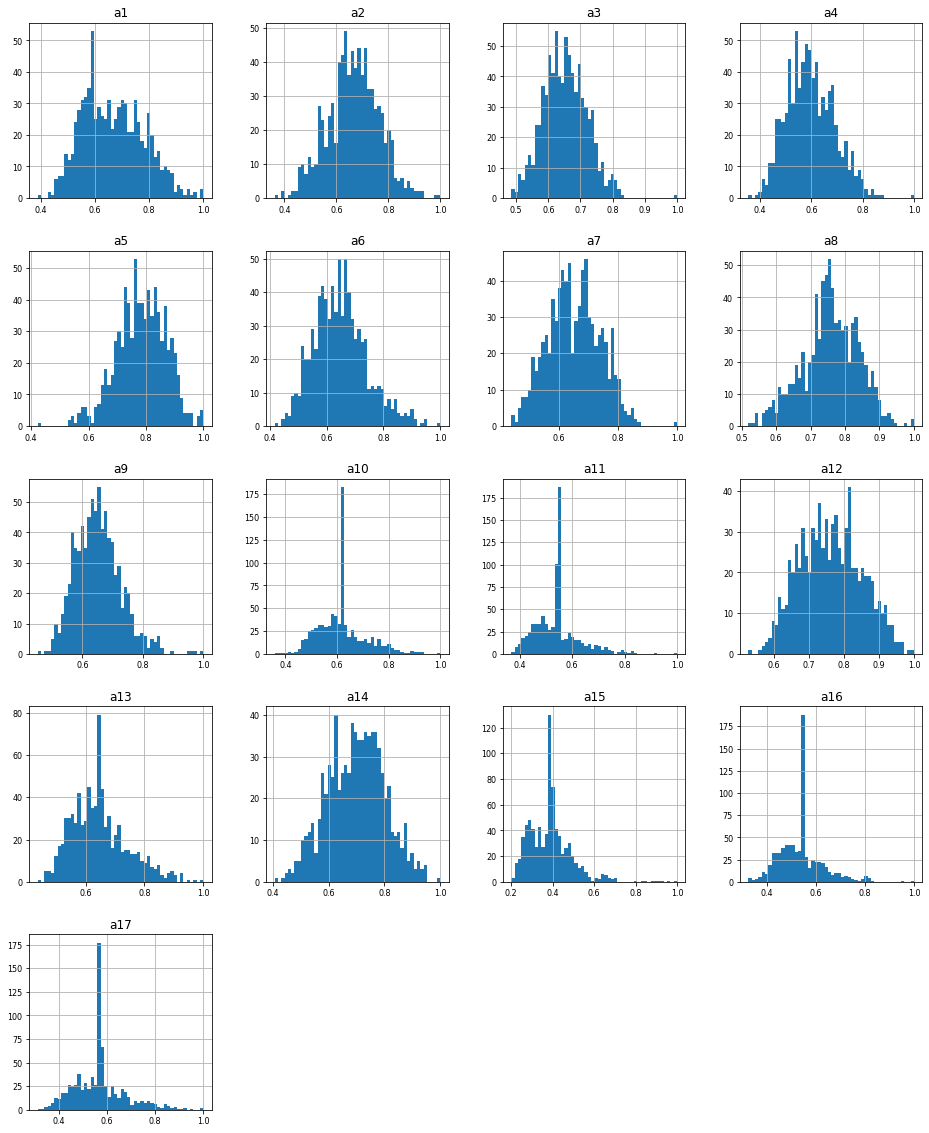

In [12]:
# view normalized dataframe

%matplotlib inline
df.iloc[:, :].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 

In [13]:
#split training data and testing data
X_test = df[df.index>=test_index]
df = df[df.index<test_index]

#set validation data
X_val = df[df.index>=valid_index]

#remove labels which the records had been dropped in preprocessing 
y = pd.DataFrame(y[df.index.tolist()])

#separate y_test from y
y_test = pd.DataFrame(y[[i for i in df.index.tolist() if i >=test_index]])
y = y[y.index<test_index]

#set validation data
y_val = y[y.index>=valid_index]

#train only with training data
X_train = df[df.index<valid_index]
y_train = y[y.index<valid_index]


# Model Training

Regarding modelling training, five types of algorithms with seven models have been built to predict the "class label". It is because we want to know what kind of mission the datasets represent. 

The algorithms used are 
1. Random Forest
2. K Nearest Neighbors, 
3. Support Vector Machine, 
4. Feedforward Neural Network and 
5. Gaussian Process Classifier. 

Meanwhile, different combinations of hyperparameters have been tested in advance to facilitate the model training. Moreover, some algorithms with other parameters are applied to examine their performance in prediction. In addition, Stratified K-fold cross-validation with two folds is used in the training dataset to utilize all available training.


In [14]:
#Apply k-folding to testing and validation data
kf = StratifiedShuffleSplit(n_splits = 2, random_state = 0)

In [15]:
#function for modeling training
def train_model(model):
    for train_indices, test_indices in kf.split(X_train, y_train):
        
        #fit training datasets with K-fold into the models
        model.fit(X_train.iloc[train_indices], y_train.iloc[train_indices].values.ravel())
        
        #show training accuracy
        print("Training accuracy: ",model.score(X_train.iloc[test_indices], y_train.iloc[test_indices].values.ravel()))
    
    return model

In [16]:
#function for display result
def display_matrix(y_pred):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred),
                               display_labels=np.unique(y_val))
    disp.plot()
    plt.show()
    print("Correct Prediction are:", sum(y_val.values.ravel() == y_pred))
    print("In Correct Prediction are:", sum(y_val.values.ravel()!= y_pred))
    print("Accuracy:", sum(y_val.values.ravel() == y_pred)/len(y_pred))
    print("="*20)

    print("Macro:", f1_score(y_val, y_pred, average='macro'))
    print("Micro", f1_score(y_val, y_pred, average='micro'))

0.8823529411764706
1.0


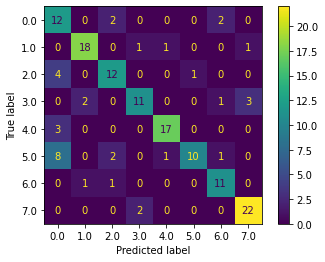

Correct Prediction are: 113
In Correct Prediction are: 37
Accuracy: 0.7533333333333333
Macro: 0.7468014909865446
Micro 0.7533333333333333


In [17]:
# initialise a random forest regression model with turning hyperparameters
model_rfc = RandomForestClassifier(n_estimators = 50, warm_start = True, criterion = 'entropy',random_state=2)

#train model
for train_indices, test_indices in kf.split(X_train, y_train):
    model_rfc.fit(X_train.iloc[train_indices], y_train.iloc[train_indices].values.ravel())
    model_rfc.n_estimators += 50
    print(model_rfc.score(X_train.iloc[test_indices], y_train.iloc[test_indices].values.ravel()))
        
#predict X_val with trained model
y_pred_rfc = model_rfc.predict(X_val)

#display predicted result
display_matrix(y_pred_rfc)

Training accuracy:  0.8431372549019608
Training accuracy:  0.9019607843137255


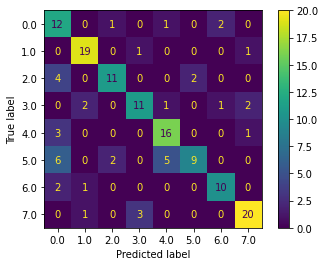

Correct Prediction are: 108
In Correct Prediction are: 42
Accuracy: 0.72
Macro: 0.71389475155065
Micro 0.72


In [18]:
# initialise another random forest regression model with default setting
model_rfc2 = RandomForestClassifier()

#train model
model_rfc2 = train_model(model_rfc2)    

#predict X_val with trained model
y_pred_rfc2 = model_rfc2.predict(X_val)

#display predicted result
display_matrix(y_pred_rfc2)

Training accuracy:  0.9215686274509803
Training accuracy:  0.9411764705882353


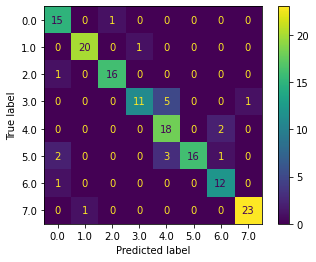

Correct Prediction are: 131
In Correct Prediction are: 19
Accuracy: 0.8733333333333333
Macro: 0.8686888898816846
Micro 0.8733333333333333


In [19]:
# initialise a random KNN model with turning hyperparameters
model_knc = KNeighborsClassifier(n_neighbors = 1)

#train model
model_knc = train_model(model_knc)    

#predict X_val with trained model
y_pred_knc = model_knc.predict(X_val)

#display predicted result
display_matrix(y_pred_knc)

Training accuracy:  0.8627450980392157
Training accuracy:  0.9019607843137255


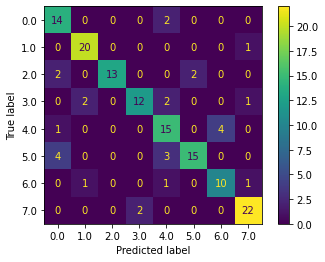

Correct Prediction are: 121
In Correct Prediction are: 29
Accuracy: 0.8066666666666666
Macro: 0.8015391241438825
Micro 0.8066666666666665


In [20]:
# initialise a SVM model with turning hyperparameters
model_svc = SVC(C = 1, kernel = 'poly',degree = 8)

#train model
model_svc = train_model(model_svc)    

#predict X_val with trained model
y_pred_svc = model_svc.predict(X_val)

#display predicted result
display_matrix(y_pred_svc)

Training accuracy:  0.7058823529411765
Training accuracy:  0.8431372549019608


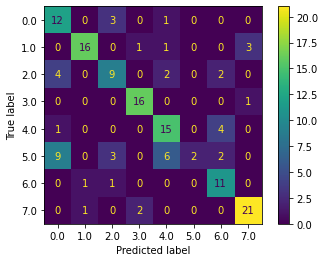

Correct Prediction are: 102
In Correct Prediction are: 48
Accuracy: 0.68
Macro: 0.650532627095127
Micro 0.68


In [21]:
# initialise SVM model with default setting
model_svc2 = SVC()

#train model
model_svc2 = train_model(model_svc2)    

#predict X_val with trained model
y_pred_svc2 = model_svc2.predict(X_val)

#display predicted result
display_matrix(y_pred_svc2)

Training accuracy:  0.6862745098039216
Training accuracy:  0.8431372549019608


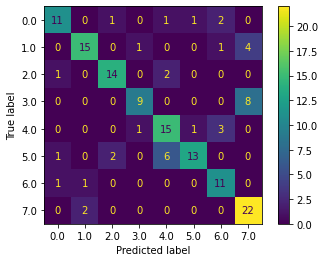

Correct Prediction are: 110
In Correct Prediction are: 40
Accuracy: 0.7333333333333333
Macro: 0.7306781955869177
Micro 0.7333333333333333


In [112]:
# initialise a FF-NN model with turning hyperparameters
model_mlp = MLPClassifier(max_iter = 1000,hidden_layer_sizes=(256, 256, 256), batch_size = 128)

#train model
model_mlp = train_model(model_mlp)    

#predict X_val with trained model
y_pred_mlp = model_mlp.predict(X_val)

#display predicted result
display_matrix(y_pred_mlp)

Training accuracy:  0.9215686274509803
Training accuracy:  0.9607843137254902


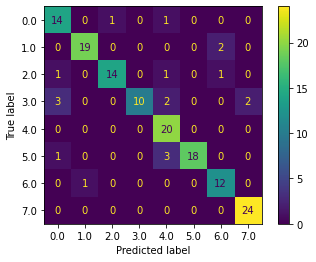

Correct Prediction are: 131
In Correct Prediction are: 19
Accuracy: 0.8733333333333333
Macro: 0.8638470869954393
Micro 0.8733333333333333


In [23]:
# initialise a GPC model with turning hyperparameters
kernel = 1.0 * RBF(1.0)
model_gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)

#train model
model_gpc = train_model(model_gpc)    

#predict X_val with trained model
y_pred_gpc = model_gpc.predict(X_val)

#display predicted result
display_matrix(y_pred_gpc)

## Summary

From the above results, we can summarize the prediction of the models. 

On one hand, models using K-Nearest Classifier (KNC) and Gaussian Process Classifier (GPC) perform well with an accuracy higher than 87%, followed by SVC Classifier (SVC) with an accuracy of about 80%. On the other hand, some models, such as Neural Network Classifier (MLP), had relatively poor predictions. Nevertheless, some models had a similar algorithm but showed different levels of accuracy, like SVM with the polynomial kernel (model SVC) and with radial basis function kernel (model SVC2).

Still, models using Random Forest (RFC2) and model SVC2, which have worse accuracies among the models, show good recalls and precisions on specific labels. To be precise, after investigating the models, we found that model RFC and model SVC2 have the best recalls and precisions on labels "4" and "3", respectively. 

In other words, we could take advantage of these weak models and establish a combined model against different predictions. It is achieved by dropping the models' predictions with low recalls and precisions while keeping their strong prediction on specific labels by model ensembling.


<h1>Model Ensembling</h1>

After tuning and testing different combinations of models taking the models' recalls and precisions into account, we could build a robust model with higher accuracy and F-1 score than a single model. With the aid of the ensembled model, we achieved 94.6% accuracy and 94.3% Macro F-1 scoring in the validation dataset.

In [119]:
#Drop columns in predictions where the model is weak at 
#Choose model with strong prediction on specific columns

#Drop values which the model is weak of
def drop_prediction(y_pred, lst):
    y_pred = y_pred.astype('float')
    for x in lst:
        y_pred[y_pred == x] = np.NAN
    return y_pred

#drop the prediction where the model is weak at
pred_ensemble = {
    model_rfc: [0,1,2,6,7],
    model_rfc2: [0,1,3,4,5],
    model_knc: [4],
    model_svc: [0,1,4,6],
    model_svc2: [0,2,4,6,7],
    model_mlp: [0,1,2,4,6,7],
    model_gpc: [0,6]
}

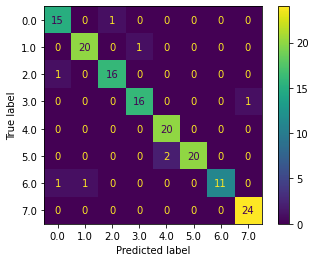

Correct Prediction are: 142
In Correct Prediction are: 8
Accuracy: 0.9466666666666667
Macro: 0.9431056513514496
Micro 0.9466666666666667


In [120]:
#create a list containing prediction sets
y_pred_val = []

#drop the weak prediction and ensemble the result
for model, drop_col in pred_ensemble.items():
    y_pred_val.append(drop_prediction(model.predict(X_val),drop_col))

#create a np.array for the prediction
y_pred_val = np.array(y_pred_val)

#get the mode of prediction
y_pred_val = st.mode(y_pred_val, nan_policy = 'omit')

#flatten the array 
y_pred_val = np.ravel(y_pred_val[0])

#show result
display_matrix(y_pred_val)

In [121]:
#predict the test datasets 
y_pred_test = []

#drop the weak prediction and ensemble the result
for model, drop_col in pred_ensemble.items():
    y_pred_test.append(drop_prediction(model.predict(X_test),drop_col))

#create a np.array for the prediction
y_pred_test = np.array(y_pred_test)

#get the mode of prediction
y_pred_test = st.mode(y_pred_test, nan_policy = 'omit')

#flatten the array 
y_pred_test = np.ravel(y_pred_test[0])


In [123]:
np.savetxt('./test_prediction.csv',y_pred_test ,delimiter=',')

# Running Time and Resources

As far as the running time are resources are concerned, the program runs on a virtual machine on Kaggle with 52 seconds in generating the profile report and 180 seconds in running the rest, in total 232s for the whole program without GPU. At the same time, the peak usages for CPU and RAM are around 200% (2 vCPU) and 1.7 GB, respectively.  

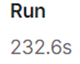

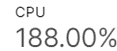

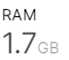

# Conclusion

In conclusion, we investigated the performance of different models in predicting the result. We found that other models have their strengths and weaknesses in predicting certain labels. However, after evaluating their characteristics with recalls and precisions, we achieved an impressive ensembled model with around a 7% increase in accuracy and F-1 score than the best single models. Therefore, model ensembling is effective in predicting the validation datasets. Yet, since we could not validate the ensembled model with other datasets, it might be overfitted or underfitted. In the future, if we could get more data with labels, we could finely tune the parameters in all the models and result in more generalized ensemble models.